<a href="https://colab.research.google.com/github/safal207/hello-world/blob/master/%D0%A1%D0%B0%D1%84%D0%BE%D0%BD%D0%BE%D0%B2_%D1%81%D0%BE%D1%80%D0%B5%D0%B2%D0%BD%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%22kaggle_mnist_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Соревнования по распознаванию рукописных цифр на Kaggle

Пример кода для отправки решения в соревнование Kaggle - https://www.kaggle.com/c/digit-recognizer


Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

In [293]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Настраиваем Kaggle API

Загружаем токен аутентификации

In [294]:
file = files.upload()

Saving kaggle.json to kaggle.json


In [295]:
!ls

gdrive	     sample_data	    submission.csv  test.csv.zip  train.csv.zip
kaggle.json  sample_submission.csv  test.csv	    train.csv


Копируем токен в каталог .kaggle

In [296]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## Загружаем данные с сайта Kaggle

In [297]:
!kaggle competitions download -c digit-recognizer

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [298]:
!ls

gdrive	     sample_submission.csv  test.csv	  train.csv
sample_data  submission.csv	    test.csv.zip  train.csv.zip


In [299]:
!unzip test.csv.zip

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


In [300]:
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [301]:
!ls

gdrive	     sample_submission.csv  test.csv	  train.csv
sample_data  submission.csv	    test.csv.zip  train.csv.zip


## Проверяем формат данных

Данные для обучения

In [302]:
!head train.csv

label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel1

Данные для тестирования

In [303]:
!head test.csv

pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pix

Пример файла с решением

In [304]:
!head sample_submission.csv

ImageId,Label
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Подготовка данных для обучения сети

Загружаем данные для обучения из файла

In [305]:
train_dataset = np.loadtxt('train.csv', skiprows=1, delimiter=',')

In [306]:
train_dataset[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Выделяем данные для обучения

In [307]:
x_train = train_dataset[:, 1:]
# Переформатируем данные в 2D, бэкенд TensorFlow
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

Нормализуем данные для обучения

In [308]:
x_train /= 255.0

In [309]:
x_train[1].shape

(28, 28, 1)

Выделяем правильные ответы

In [310]:
y_train = train_dataset[:, 0]

In [311]:
y_train[:5]

array([1., 0., 1., 4., 0.])

Преобразуем ответы в формат one hot encoding

In [312]:
y_train = utils.to_categorical(y_train)

In [313]:
y_train[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Разделяем набор данных на две части: для обучения (X_Train, Y_train) и проверки (X_val, Y_val)

In [314]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(x_train,
                                                  y_train, 
                                                  test_size = 0.1,
                                                  random_state=random_seed)

In [315]:
X_train.shape

(37800, 28, 28, 1)

Создаем генератор для расширения данных

In [360]:
datagen = ImageDataGenerator(
        rotation_range=30,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

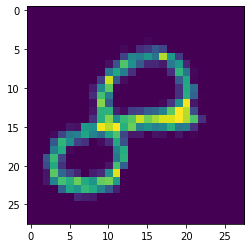

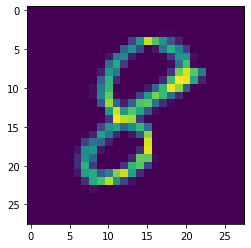

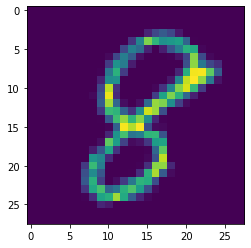

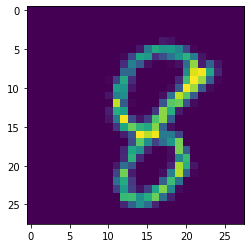

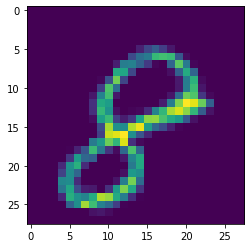

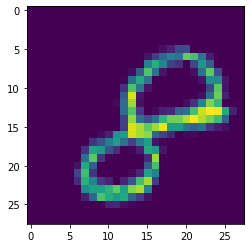

In [361]:
i = 0
data = X_train[0]
data = np.expand_dims(data, axis=0)
for batch in datagen.flow(data, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0][:,:,0])
    i += 1
    if i % 6 == 0:
        break
plt.show()

## Создаем нейронную сеть

**Создаем последовательную модель**

In [453]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

**Компилируем сеть**

In [454]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 64)         

## Обучаем нейронную сеть

In [455]:
filepath = 'mnist-cnn.h5'


In [456]:
from tensorflow.keras.callbacks import ModelCheckpoint


In [457]:
сheckpoint = ModelCheckpoint( filepath, 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1,
                              model = 'auto' )

In [458]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [459]:
batch_size=96

In [460]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size), 
                    epochs=30,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=1,
                    callbacks=[сheckpoint, learning_rate_reduction])

Epoch 1/30
393/393 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.7994
Epoch 00001: val_accuracy improved from -inf to 0.97310, saving model to mnist-cnn.h5
393/393 [==============================] - 12s 30ms/step - loss: 0.6018 - accuracy: 0.7994 - val_loss: 0.0945 - val_accuracy: 0.9731
Epoch 2/30
393/393 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9520
Epoch 00002: val_accuracy improved from 0.97310 to 0.98310, saving model to mnist-cnn.h5
393/393 [==============================] - 12s 30ms/step - loss: 0.1621 - accuracy: 0.9520 - val_loss: 0.0535 - val_accuracy: 0.9831
Epoch 3/30
393/393 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.9661
Epoch 00003: val_accuracy improved from 0.98310 to 0.98762, saving model to mnist-cnn.h5
393/393 [==============================] - 12s 30ms/step - loss: 0.1178 - accuracy: 0.9661 - val_loss: 0.0420 - val_accuracy: 0.9876
Epoch 4/30
393/393 [=============================

In [461]:
 model.load_weights('mnist-cnn.h5')

## Визуализация качества обучения


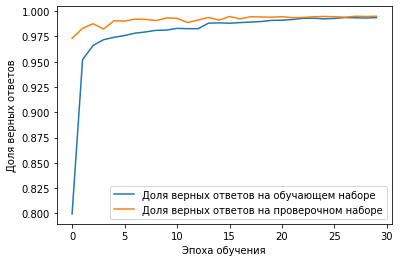

In [465]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем данные для распознавания

In [466]:
test_dataset = np.loadtxt('test.csv', skiprows=1, delimiter=",")

In [467]:
test_dataset[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [468]:
x_test = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)


Нормализация данных

In [469]:
x_test = x_test / 255.0

## Запускаем распознавание рукописных цифр из тестового набора данных

In [470]:
predictions = model.predict(x_test)

In [471]:
predictions[:5]

array([[6.5549618e-15, 1.5427766e-12, 1.0000000e+00, 4.6798271e-10,
        5.7629324e-10, 3.8218625e-12, 1.5226571e-13, 4.1562039e-08,
        9.2685593e-10, 6.1599120e-10],
       [9.9999976e-01, 7.4446898e-12, 6.3623515e-09, 6.6120456e-11,
        4.8118864e-10, 9.2843577e-10, 1.4597143e-07, 9.1871188e-10,
        4.1109171e-08, 1.1198401e-07],
       [2.5350287e-08, 3.8780756e-09, 1.7123901e-06, 2.5988192e-07,
        6.3691405e-05, 4.2212395e-08, 1.5513058e-08, 2.5288293e-07,
        9.8990968e-05, 9.9983490e-01],
       [9.9341255e-01, 2.2945314e-06, 8.1438680e-05, 3.2651409e-05,
        1.0504285e-05, 1.1246381e-05, 1.5117726e-04, 2.7342561e-05,
        1.2997262e-03, 4.9712253e-03],
       [3.0119414e-15, 2.7126532e-14, 3.8926362e-12, 1.0000000e+00,
        1.9495102e-18, 3.8002268e-10, 9.6858319e-15, 7.5960939e-14,
        9.7547463e-11, 4.9778836e-12]], dtype=float32)

Преобразуем результаты распознавания из формата one hot encoding в цифры

In [472]:
predictions = np.argmax(predictions, axis=1)

In [473]:
predictions[:5]

array([2, 0, 9, 0, 3])

## Готовим файл с решением для Kaggle

In [474]:
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))

In [475]:
out[:5]


array([[1, 2],
       [2, 0],
       [3, 9],
       [4, 0],
       [5, 3]])

Записываем результаты в файл 

In [476]:
np.savetxt('submission.csv', out, header="ImageId,Label", 
            comments="", fmt="%d,%d")

In [477]:
!head submission.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


## Отправляем решение на соревнование

In [479]:
!kaggle competitions submit -c digit-recognizer -m "Submition from Colab" -f submission.csv

100% 208k/208k [00:03<00:00, 62.2kB/s]
403 - Your team has used its submission allowance (5 of 5). This resets at midnight UTC (11 hours from now).
